# remake figure 4 from Feng et al.

Newer version of Figure 4:
* Compare SP-E3SM, E3SM, obs, WRF
* Locations
  * Obs: 
    * FACETS stats: /global/cscratch1/sd/feng045/FACETS/obs/stats_25km_testno10mm/robust_mcs_tracks_20??0301_20??1031.nc
    * 2019 paper: /global/project/projectdirs/m1867/zfeng/usa/gridrad/stats_linkpf/monthly/mcs_rainmap_*.nc
  * WRF-Thompson:
    * /global/project/projectdirs/m1867/zfeng/usa/wrf/LGdm.THOM2011/statstb/LGdm.THOM2011_mcs_rainmap_2011??.nc
    * /global/project/projectdirs/m1867/zfeng/usa/wrf/LGdm.THOM2011/mcstracking/
  * WRF-Morrison:
    * /global/project/projectdirs/m1867/zfeng/usa/wrf/LGdm.MORR2011/statstb/LGdm.MORR2011_mcs_rainmap_2011??.nc
    * /global/project/projectdirs/m1867/zfeng/usa/wrf/LGdm.MORR2011/mcstracking
    
Also:
* track down what the "other" is all about. Hypothesis: it's either stuff that goes into Canada, or is over water

From Zhe's email:
```Chris,
I have the monthly average statistics for the 2011 simulations for both Thompson and Morrison microphysics, but I don’t have the 2012 because it wasn’t used in my 2018 paper.  They’re on the WACCEM project directory below. 
 
Thompson:
/global/project/projectdirs/m1867/zfeng/usa/wrf/LGdm.THOM2011/statstb/LGdm.THOM2011_mcs_rainmap_2011??.nc
Morrison:
/global/project/projectdirs/m1867/zfeng/usa/wrf/LGdm.MORR2011/statstb/LGdm.MORR2011_mcs_rainmap_2011??.nc
Observations (from 2019 paper)
/global/project/projectdirs/m1867/zfeng/usa/gridrad/stats_linkpf/monthly/mcs_rainmap_*.nc
 
Note that I only have MCS precipitation frequency and amount in these files, not the number of MCS, as those calculations were recently added in my 2019 paper.  But they can be calculated using the hourly pixel-level tracking outputs:
 
Thompson:
/global/project/projectdirs/m1867/zfeng/usa/wrf/LGdm.THOM2011/mcstracking
Morrison:
/global/project/projectdirs/m1867/zfeng/usa/wrf/LGdm.MORR2011/mcstracking
 
Let me know if you have any problem accessing these files.
Thanks,
 
-----------------------
-Zhe Feng
```

In [61]:
%matplotlib inline
import xarray as xr
from glob import glob
import numpy as np
import pandas as pd
import cartopy.crs as ccrs   # map plots
import cartopy.feature as cfeature
from e3sm_utils import cmclimate
cmap_prect = cmclimate.cm.WhiteBlueGreenYellowRed
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

## Regional definitions using shapefiles

In [62]:
import shapely.geometry as sgeom
import cartopy.io.shapereader as shpreader
from shapely.ops import unary_union
from shapely.prepared import prep

In [88]:
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m',
                                     category='cultural', name=shapename)
# also need to add in "not land" and "Canada" :/
countries_shp = shpreader.natural_earth(resolution='110m', category='cultural',
                                        name='admin_0_countries')
land_shp = shpreader.natural_earth(resolution='110m', category='physical',
                                   name='land')
ocean_shp = shpreader.natural_earth(resolution='110m', category='physical',
                                    name='ocean')
lakes_shp = shpreader.natural_earth(resolution='110m', category='physical',
                                    name='lakes')
reader = shpreader.Reader(states_shp)
states = reader.records()

In [160]:
sgp_states = ['New Mexico', 'Texas', 'Oklahoma', 'Arkansas']
southeast_states = ['Louisiana', 'Mississippi', 'Alabama', 'Tennessee', 'Georgia', 'Florida', 'South Carolina', 'North Carolina']
ngp_states = ['Montana', 'Wyoming', 'Colorado', 'North Dakota', 'South Dakota', 'Nebraska', 'Kansas',
              'Minnesota', 'Iowa', 'Missouri', 'Wisconsin', 'Illinois', 'Indiana']
ne_states = ['Michigan', 'Ohio', 'Kentucky', 'Virginia', 'West Virginia', 'Massachusetts', 'Maryland', 'Connecticut', 
             'Pennsylvania', 'New York', 'Maine', 'Vermont', 'New Hampshire', 'Rhode Island', 'Delaware', 'New Jersey', 
             'District Of Columbia']
west_states = ['Washington', 'Idaho', 'Oregon', 'California', 'Nevada', 'Arizona', 'Utah']

geoms = [g for g in shpreader.Reader(states_shp).geometries()]
recs = [r for r in shpreader.Reader(states_shp).records()]

region_geoms = {}
for key, val in {'sgp': sgp_states,
                 'ngp': ngp_states,
                 'seast': southeast_states,
                 'ne': ne_states,
                 'west': west_states}.items():
    rgn_geoms = unary_union([rec.geometry for rec in recs if rec.attributes['name'] in val])
    region_geoms[key] = prep(rgn_geoms)

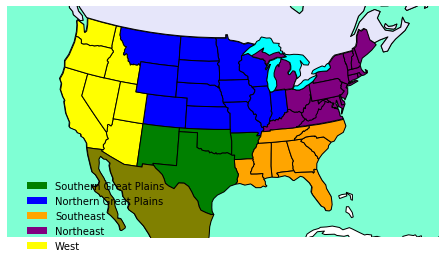

In [147]:
ax = plt.axes([0, 0, 1, 1],
              projection=ccrs.LambertConformal())
ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
# to get the effect of having just the states without a map "background"
# turn off the outline and background patches
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)

for rec, state in zip(shpreader.Reader(states_shp).records(), shpreader.Reader(states_shp).geometries()):
    # pick a default color for the land with a black outline,
    facecolor = [0.9375, 0.9375, 0.859375]
    edgecolor = 'black'

    if rec.attributes['name'] in sgp_states:
        facecolor = 'green'
    elif rec.attributes['name'] in ngp_states:
        facecolor = 'blue'
    elif rec.attributes['name'] in southeast_states:
        facecolor = 'orange'
    elif rec.attributes['name'] in ne_states:
        facecolor = 'purple'
    elif rec.attributes['name'] in west_states:
        facecolor = 'yellow'

    ax.add_geometries([state], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor=edgecolor)

for oc in shpreader.Reader(ocean_shp).geometries():
    facecolor = 'aquamarine'
    edgecolor = 'black'
    ax.add_geometries([oc], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor=edgecolor)

for rec in shpreader.Reader(countries_shp).records():
    if rec.attributes['NAME'] == 'Canada':
        facecolor = 'lavender'
    elif rec.attributes['NAME'] == 'Mexico':
        facecolor = 'olive'
    else:
        continue
    ax.add_geometries([rec.geometry], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor=edgecolor)
    
# lakes:
for rec in shpreader.Reader(lakes_shp).records():
    if rec.attributes['name_alt'] == 'Great Lakes':
        facecolor = 'aqua'
        ax.add_geometries([rec.geometry], ccrs.PlateCarree(),
                          facecolor=facecolor, edgecolor=edgecolor)

    
    
# make proxy artists to add to a legend
sgp = mpatches.Rectangle((0, 0), 1, 1, facecolor="green")
ngp = mpatches.Rectangle((0, 0), 1, 1, facecolor="blue")
seast = mpatches.Rectangle((0, 0), 1, 1, facecolor="orange")
neast = mpatches.Rectangle((0, 0), 1, 1, facecolor="purple")
west = mpatches.Rectangle((0, 0), 1, 1, facecolor="yellow")
plt.legend([sgp, ngp, seast, neast, west], ['Southern Great Plains', 'Northern Great Plains', 'Southeast', 'Northeast', 'West'],
           loc='lower left', bbox_to_anchor=(0.025, -0.1), frameon=False);

In [171]:
# For classifying other regions
other_regions = {'Canada': None, 'Mexico': None,
                 'Ocean': None, 'Great Lakes': None}

# west no longer in other
# west_region = prep(unary_union([rec.geometry for rec in recs if rec.attributes['name'] in west_states]))
# other_regions['Western US'] = west_region

for rec in shpreader.Reader(countries_shp).records():
    if rec.attributes['NAME'] == 'Canada':
        other_regions['Canada'] = rec.geometry
    elif rec.attributes['NAME'] == 'Mexico':
        other_regions['Mexico'] = rec.geometry
other_regions['Ocean'] = prep(unary_union([oc for oc in shpreader.Reader(ocean_shp).geometries()]))

# note
great_lakes = [rec.geometry for rec in shpreader.Reader(lakes_shp).records() if rec.attributes['name_alt'] == 'Great Lakes']
other_regions['Great Lakes'] = prep(unary_union(great_lakes))

print(other_regions)

{'Canada': <shapely.geometry.multipolygon.MultiPolygon object at 0x2aaae66286a0>, 'Mexico': <shapely.geometry.multipolygon.MultiPolygon object at 0x2aaae2e0dd68>, 'Ocean': <shapely.prepared.PreparedGeometry object at 0x2aaae62a8320>, 'Great Lakes': <shapely.prepared.PreparedGeometry object at 0x2aaae4a096a0>}


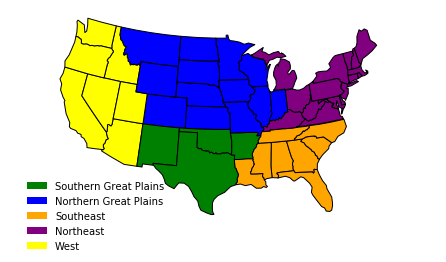

In [75]:
ax = plt.axes([0, 0, 1, 1],
              projection=ccrs.LambertConformal())
ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
# to get the effect of having just the states without a map "background"
# turn off the outline and background patches
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)

for rec, state in zip(shpreader.Reader(states_shp).records(), shpreader.Reader(states_shp).geometries()):
    
    # pick a default color for the land with a black outline,
    facecolor = [0.9375, 0.9375, 0.859375]
    edgecolor = 'black'

    if rec.attributes['name'] in sgp_states:
        facecolor = 'green'
    elif rec.attributes['name'] in ngp_states:
        facecolor = 'blue'
    elif rec.attributes['name'] in southeast_states:
        facecolor = 'orange'
    elif rec.attributes['name'] in ne_states:
        facecolor = 'purple'
    elif rec.attributes['name'] in west_states:
        facecolor = 'yellow'

    ax.add_geometries([state], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor=edgecolor)
    
# make proxy artists to add to a legend
sgp = mpatches.Rectangle((0, 0), 1, 1, facecolor="green")
ngp = mpatches.Rectangle((0, 0), 1, 1, facecolor="blue")
seast = mpatches.Rectangle((0, 0), 1, 1, facecolor="orange")
neast = mpatches.Rectangle((0, 0), 1, 1, facecolor="purple")
west = mpatches.Rectangle((0, 0), 1, 1, facecolor="yellow")
plt.legend([sgp, ngp, seast, neast, west], ['Southern Great Plains', 'Northern Great Plains', 'Southeast', 'Northeast', 'West'],
           loc='lower left', bbox_to_anchor=(0.025, -0.1), frameon=False);

## Selection definitions

After doing a breakdown of regions, it looks like most of the "other" category is ocean (so MCSs that start over land but make their way to sea), Canada, then Mexico.

In the second round of selections, I will ignore any points that would be categorized as "ocean" (i.e., will assign them to the US category that makes sense). Same with Canada and Mexico. Those in the Western US will be flagged as such, too. This may need to be restricted based on what happens in the other data ...

In [6]:
nlon = 320
nlat = 120
months = np.arange(3, 11)

In [211]:
def select_case(name):
    topdir = '/global/cscratch1/sd/crjones/ECP/' + name
    robust_files = sorted(glob(topdir + '/statstb/robust_mcs_tracks*.nc'))
    count_dir = '/global/cscratch1/sd/crjones/ECP/' + case + '/monthly_mcs_count_land_only.nc'
    if 'e3sm-mmf' in topdir:
        years = pd.date_range(start='2001', end='2008', freq='A-JUN')
    else:
        years = pd.date_range(start='2001', end='2004', freq='A-JUN')
    return topdir, robust_files, years, xr.open_dataset(count_dir)

In [8]:
def calc_mean_position(this_track, require_mcs_status=True):
    """Use largest pf"""
    pf = this_track.isel(nmaxpf=0)  # largest pf
    if require_mcs_status:
        pf = pf.where(pf.pf_mcsstatus == 1)
    lons = pf.pf_lon.values
    lats = pf.pf_lat.values
    valid_pos = ~np.isnan(lons + lats)
    lons = lons[valid_pos]
    lats = lats[valid_pos]
    lons[lons > 180] = lons[lons > 180] - 360
    month = int(np.round(pf['base_time.month'].mean()).item())
    return lons, lats, month

In [9]:
topdir, robust_files, years, dsa = select_case('e3sm')

In [10]:
ds = xr.open_dataset(robust_files[0])
this_track = ds.isel(tracks=10)

In [32]:
lon0 = this_track.meanlon.values[0]
lon0 = lon0 - 360 if lon0 > 180 else lon0
print(lon0)

-82.85238647460938


In [167]:
def assign_region(regions, other=None):
    """
    regions = dictionary: {region_name: count}
    other (optional) = dictionary like regions with 'other' categories to exclude
    """
    if other is not None:
        regions = {**regions, **other}  # join together
    region_id = max(regions, key=regions.get)  # identify region as the one with max stats
    # double-check that not evenly spread between two regions:
    max_val = max(this_region.values())
    if sum([v == max_val for v in this_region.values()]) > 1:
        print('multiple regions are match')
        print(this_region)
        region_id = 'tie'

    
    pass

def select_mcs_region(this_track, region_geoms, minlen=100, other_geoms=None, debug=False):
    if this_track.majoraxislength.max().item() < minlen:
        print('track never large enough')
        return None
    lons, lats, month = calc_mean_position(this_track)

    # just require it spend more time in this region than others ...
    this_region = {reg: 0 for reg in region_geoms.keys()}
    if other_geoms is not None:
        for key in other_geoms.keys():
            this_region['-'.join(['other', key])] = 0
    lon0 = this_track.meanlon.values[0]
    if lon0 > 180:
        lon0 = lon0 - 360
    p0 = sgeom.Point(lon0, this_track.meanlat.values[0])
    origin = 'other'
    for reg, geom in region_geoms.items():
        if geom.contains(p0):
            origin = reg
            continue
    # classify origin if other
    if origin == 'other': 
        for reg, geom in other_regions.items():
            if geom.contains(p0):
                origin = '-'.join(['other', reg])
                continue
    total_count = len(lons)
    
    if debug:
        # will keep list of regions, too ...
        regional_breakdown = {}
    for coords in zip(lons, lats):
        if debug:
            regional_breakdown[coords] = []
        point = sgeom.Point(*coords)
        for reg, geom in region_geoms.items():
            this_region[reg] += geom.contains(point)  # count which point is in which region
            if debug and geom.contains(point):
                regional_breakdown[coords].append(reg)
        if other_geoms is not None:
            for reg, geom in other_geoms.items():
                kreg = '-'.join(['other', reg])
                this_region[kreg] += geom.contains(point)
                if debug and geom.contains(point):
                    regional_breakdown[coords].append(reg)
    other = total_count - sum(reg_count for reg_count in this_region.values())
    if (not debug) and (other < 0):
        # something is weird here, let's see the details by cranking this out with debug:
        return select_mcs_region(this_track, region_geoms, minlen, other_geoms, debug=True)
    this_region['other'] = other
    # this_region['total'] = total_count
    region_id = max(this_region, key=this_region.get)  # identify region as the one with max stats
    # double-check that not evenly spread between two regions:
    max_val = max(this_region.values())
    if sum([v == max_val for v in this_region.values()]) > 1:
        print('multiple regions are match')
        print(this_region)
        region_id = 'tie'
    if debug:
        print({key: val for key, val in regional_breakdown.items() if len(val) > 1})
    return region_id, month, origin

In [212]:
def assign_mcs_region(regions, other=None, exclude=['Canada', 'Mexico', 'Ocean', 'Great Lakes'],
                      min_to_count=3):
    """
    regions = dictionary: {region_name: count}
    other (optional) = dictionary like regions with 'other' categories to exclude
    """
    if other is not None:
        regions = {**regions, **other}  # join together
    regions_to_check = {key: val for key, val in regions.items() if key not in exclude}
    # this works great if they don't tie ...
    # region_id = max(regions_to_check, key=regions.get)  # identify region as the one with max stats
    max_val = max(regions_to_check.values())
    if max_val < min_to_count:
        print('Excluded because max_val = {}'.format(max_val))
        return []
    return [key for key, value in regions_to_check.items() if value == max_val]  # returns a list

def categorize_point(point, regions, prioritize=['Canada', 'seast']):
    candidates = []
    for reg, geom in regions.items():
        if geom.contains(point):
            candidates.append(reg)
    if not candidates:
        print('Uncategorized point {}'.format(point))
        return 'other'
    if len(candidates) == 1:
        return candidates[0]
    # otherwise, multiple candidate regions.
    print('Multiple regions for point {}: '.format(point), candidates)
    for priority in prioritize:
        if priority in candidates:
            print('Prioritizing ' + priority)
            return priority
    return candidates

uncategorized_pts = []
def select_mcs_region_new(this_track, region_geoms, minlen=100, other_geoms=None, debug=False):
    if this_track.majoraxislength.max().item() < minlen:
        print('track never large enough')
        return None
    if other_geoms is not None:
        region_geoms = {**region_geoms, **other_geoms}
    lons, lats, month = calc_mean_position(this_track)
    total_count = len(lons)

    lon0 = this_track.meanlon.values[0]
    if lon0 > 180:
        lon0 = lon0 - 360
    lat0 = this_track.meanlat.values[0]
    p0 = sgeom.Point(lon0, lat0)
    
    # categorize the origin
    origin = categorize_point(p0, region_geoms)
    if isinstance(origin, list):
        print('Debug this origin: ')
        print(origin)
        print(lon0, lat0)
    
    # just require it spend more time in this region than others ...
    this_region = {reg: 0 for reg in region_geoms.keys()}
    this_region['other'] = 0
    if debug:
        # will keep full list of regions for each point
        regional_breakdown = {}
    for coords in zip(lons, lats):
        point = sgeom.Point(*coords)
        region = categorize_point(point, region_geoms)
        if region == 'other':
            uncategorized_pts.append(point)
        if debug:
            regional_breakdown[coords] = categorize_point(point, region_geoms, prioritize=None)
        if isinstance(region, list):
            # next line will shulre break
            print('Debug this region: ')
            print(region)
            print(coords)
        this_region[region] += 1
    other = total_count - sum(reg_count for reg_count in this_region.values())
    if (not debug) and (other < 0):
        # something is weird here, let's see the details by cranking this out with debug:
        return select_mcs_region_new(this_track, region_geoms, minlen, other_geoms, debug=True)
    if debug:
        print({key: val for key, val in regional_breakdown.items() if len(val) > 1})
    region_id = assign_mcs_region(this_region)
    return region_id, month, origin

all_regions = [key for key in region_geoms.keys()] + [key for key in other_regions.keys()] + ['other']
regional_results = {(reg, mon): [] for reg in all_regions for mon in months}

the_cases = ['e3sm', 'e3sm-mmf']
summary = {}
origin_summary = {}
for case in the_cases:
    topdir, robust_files, years, ds_init = select_case(case)
    results = {}
    origins = {(reg1, reg2): 0 for reg1 in all_regions for reg2 in all_regions}
    for iyr, robust_mcs_filename in enumerate(robust_files):
        print('processing file {}'.format(robust_mcs_filename))
        ds = xr.open_dataset(robust_mcs_filename)
        init_type = ds_init.init_loc.isel(year=iyr).values  # 1 = land, 2 = ocean
        tracks_to_process = ds.tracks.values
        regional_results = {(reg, mon): [] for reg in all_regions for mon in months}
        for track in tracks_to_process:
            if init_type[track] != 1:
                continue
            this_track = ds.isel(tracks=track)
            this_region, this_month, origin = select_mcs_region_new(this_track, region_geoms, other_geoms=other_regions)
            # accept that a single track may go into multiple regions ...
            for reg in this_region:
                regional_results[(reg, this_month)].append(track)
                if origin is not None:
                    origins[(reg, origin)] += 1 / len(this_region)
        results[iyr] = regional_results
    # post-process
    summary[case] = {key: [len(results[i][key]) for i in range(len(results))] for key in results[0].keys()}
    origin_summary[case] = origins
    print(origin_summary[case])

processing file /global/cscratch1/sd/crjones/ECP/e3sm/statstb/robust_mcs_tracks_20010301_20011031.nc
Multiple regions for point POINT (-80.57131958007812 44.89289855957031):  ['Canada', 'Great Lakes']
Prioritizing Canada
Multiple regions for point POINT (-79.77542114257812 42.7184944152832):  ['Canada', 'Great Lakes']
Prioritizing Canada
Multiple regions for point POINT (-82.19033813476562 44.30195617675781):  ['Canada', 'Great Lakes']
Prioritizing Canada
Multiple regions for point POINT (-82.06735229492188 44.87748336791992):  ['Canada', 'Great Lakes']
Prioritizing Canada
Multiple regions for point POINT (-81.84005737304688 45.48976898193359):  ['Canada', 'Great Lakes']
Prioritizing Canada
Multiple regions for point POINT (-81.51315307617188 44.55526351928711):  ['Canada', 'Great Lakes']
Prioritizing Canada
Excluded because max_val = 0
Multiple regions for point POINT (-84.89718627929688 47.05443572998047):  ['Canada', 'Great Lakes']
Prioritizing Canada
Excluded because max_val = 0
Ex

In [213]:
summary

{'e3sm': {('sgp', 3): [2, 2, 3],
  ('sgp', 4): [3, 0, 2],
  ('sgp', 5): [0, 2, 1],
  ('sgp', 6): [0, 0, 0],
  ('sgp', 7): [0, 0, 0],
  ('sgp', 8): [0, 0, 0],
  ('sgp', 9): [0, 0, 0],
  ('sgp', 10): [0, 0, 0],
  ('ngp', 3): [1, 1, 7],
  ('ngp', 4): [3, 2, 2],
  ('ngp', 5): [3, 3, 1],
  ('ngp', 6): [1, 2, 4],
  ('ngp', 7): [1, 0, 0],
  ('ngp', 8): [1, 0, 1],
  ('ngp', 9): [0, 2, 1],
  ('ngp', 10): [0, 3, 1],
  ('seast', 3): [5, 3, 4],
  ('seast', 4): [6, 6, 2],
  ('seast', 5): [1, 0, 0],
  ('seast', 6): [0, 1, 6],
  ('seast', 7): [1, 0, 0],
  ('seast', 8): [0, 0, 0],
  ('seast', 9): [0, 1, 0],
  ('seast', 10): [1, 0, 0],
  ('ne', 3): [4, 1, 2],
  ('ne', 4): [1, 1, 0],
  ('ne', 5): [3, 0, 0],
  ('ne', 6): [1, 3, 2],
  ('ne', 7): [1, 0, 0],
  ('ne', 8): [0, 2, 1],
  ('ne', 9): [0, 0, 1],
  ('ne', 10): [3, 0, 3],
  ('west', 3): [0, 0, 0],
  ('west', 4): [0, 0, 0],
  ('west', 5): [0, 0, 0],
  ('west', 6): [0, 0, 0],
  ('west', 7): [0, 0, 0],
  ('west', 8): [0, 0, 0],
  ('west', 9): [0, 0, 0]

In [177]:
# this version was in error
summary

{'e3sm': {('sgp', 3): [2, 0, 2],
  ('sgp', 4): [2, 0, 1],
  ('sgp', 5): [0, 2, 1],
  ('sgp', 6): [0, 0, 0],
  ('sgp', 7): [0, 0, 0],
  ('sgp', 8): [0, 0, 0],
  ('sgp', 9): [0, 0, 0],
  ('sgp', 10): [0, 0, 0],
  ('ngp', 3): [1, 0, 3],
  ('ngp', 4): [1, 2, 1],
  ('ngp', 5): [2, 1, 1],
  ('ngp', 6): [1, 2, 3],
  ('ngp', 7): [1, 0, 0],
  ('ngp', 8): [1, 0, 0],
  ('ngp', 9): [0, 2, 0],
  ('ngp', 10): [0, 2, 1],
  ('seast', 3): [4, 2, 1],
  ('seast', 4): [7, 5, 0],
  ('seast', 5): [0, 0, 0],
  ('seast', 6): [0, 1, 6],
  ('seast', 7): [1, 0, 0],
  ('seast', 8): [0, 0, 0],
  ('seast', 9): [0, 1, 0],
  ('seast', 10): [0, 0, 0],
  ('ne', 3): [1, 1, 1],
  ('ne', 4): [1, 1, 0],
  ('ne', 5): [2, 0, 0],
  ('ne', 6): [1, 3, 2],
  ('ne', 7): [1, 0, 0],
  ('ne', 8): [0, 2, 0],
  ('ne', 9): [1, 0, 0],
  ('ne', 10): [2, 0, 2],
  ('west', 3): [0, 0, 0],
  ('west', 4): [0, 0, 0],
  ('west', 5): [0, 0, 0],
  ('west', 6): [0, 0, 0],
  ('west', 7): [0, 0, 0],
  ('west', 8): [0, 0, 0],
  ('west', 9): [0, 0, 0]

In [214]:
len(uncategorized_pts)

113

In [215]:
# deep test
deep_categorization = {}
still_uncategorized = []

while uncategorized_pts:
    pt = uncategorized_pts.pop()
    found = False
    for rec in shpreader.Reader(countries_shp).records():
        geom = rec.geometry
        if geom.contains(pt):
            found = True
            country = rec.attributes['NAME']
            if country not in deep_categorization:
                deep_categorization[country] = [pt]
            else:
                deep_categorization[country].append(pt)
            break
    if not found:
        still_uncategorized.append(pt)
print(*[(key, len(val)) for key, val in deep_categorization.items()], sep='\n')

('Cuba', 107)
('Bahamas', 4)


In [216]:
# remaining points here are just offshore Maine, and in the Potomic River
print([str(p) for p in still_uncategorized])

['POINT (-70.32608032226562 43.44565200805664)', 'POINT (-76.88461303710938 38.19230651855469)']


In [187]:
print(*[(key, len(val)) for key, val in deep_categorization.items()], sep='\n')

('Cuba', 107)
('Bahamas', 11)


# Updated categorization breakdown

In [196]:
all_regions = ['sgp', 'ngp', 'seast', 'ne', 'west', 'other']

In [197]:
plot_colors = {'other': [0.9375, 0.9375, 0.859375],
               'sgp': 'green',
               'ngp': 'blue',
               'seast': 'orange',
               'ne': 'purple',
               'west': 'yellow'}

def parse_and_plot(summary, case):
    summary_case = summary[case]
    nreg = len(all_regions)
    nmon = len(months)
    out_mean = np.zeros((len(all_regions), len(months)))
    out_std = np.zeros((len(all_regions), len(months)))
    total_counts = {reg: 0 for reg in all_regions}
    for ir, reg in enumerate(all_regions):
        for im, month in enumerate(months):
            key = (reg, month)
            out_mean[ir, im] = np.mean(summary_case[key])
            out_std[ir, im] = np.std(summary_case[key])
            total_counts[reg] += sum(summary_case[key])
    # make the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    width = 0.8 / nreg  # the width of the bars
    for ir in range(nreg):
        reg = all_regions[ir]
        col = plot_colors[reg] if reg in plot_colors else plot_colors['other']
        lab = reg + '  ({:0.0f})'.format(np.sum(out_mean[ir, :]))
        pos = (months - 0.4) + (ir + 0.5) * width
        ax.bar(pos, out_mean[ir, :], width, yerr=out_std[ir, :], label=lab.upper(), color=col)
    ax.set_ylabel('Number of MCSs')
    ax.set_title('Number of MCSs for ' + case.upper() + ' ({} years)'.format(len(summary_case[key])))
    ax.set_xticks(months)
    ax.set_xticklabels(['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'])
    ax.legend()
    ax.set_ylim(bottom=0)
    return out_mean, out_std, ax

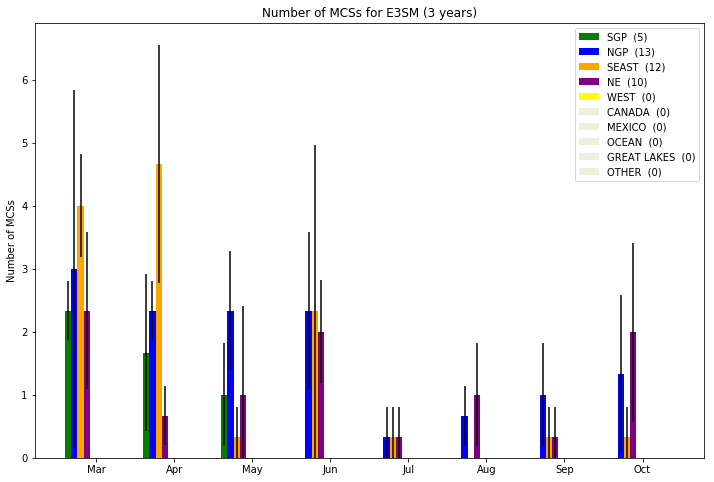

In [217]:
parse_and_plot(summary, 'e3sm');

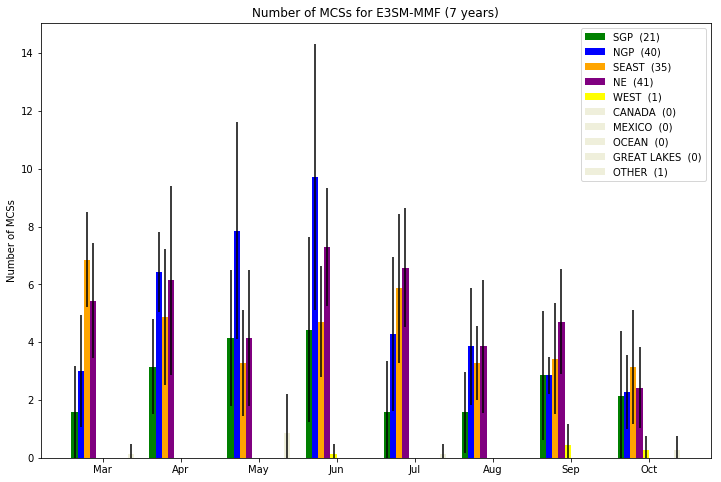

In [218]:
parse_and_plot(summary, 'e3sm-mmf');

In [201]:
import seaborn as sns
import pandas as pd

In [219]:
dfs = {}
for case, dat in origin_summary.items():
    # print(val for val in dat.values())
    ser = pd.Series(list(dat.values()),
                          index=pd.MultiIndex.from_tuples(dat.keys()))
    dfs[case] = ser.unstack().fillna(0)

Text(0.5, 1.0, 'E3SM')

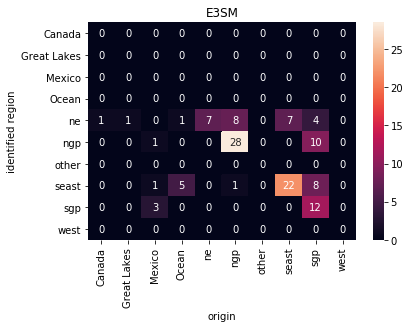

In [222]:
ax = sns.heatmap(dfs['e3sm'], annot=True, fmt='.0f')
ax.set_xlabel('origin')
ax.set_ylabel('identified region')
ax.set_title('E3SM')

Text(0.5, 1.0, 'E3SM-MMF')

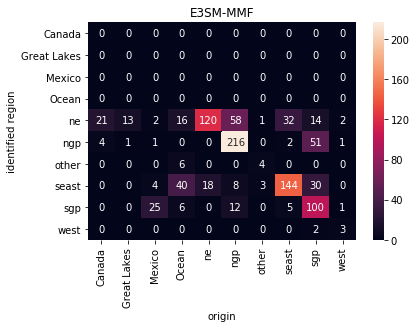

In [221]:
ax = sns.heatmap(dfs['e3sm-mmf'], annot=True, fmt='.0f')
ax.set_xlabel('origin')
ax.set_ylabel('identified region')
ax.set_title('E3SM-MMF')

# Old categorizations

In [193]:
other_regions

{'Canada': <shapely.geometry.multipolygon.MultiPolygon at 0x2aaae66286a0>,
 'Mexico': <shapely.geometry.multipolygon.MultiPolygon at 0x2aaae2e0dd68>,
 'Ocean': <shapely.prepared.PreparedGeometry at 0x2aaae62a8320>,
 'Great Lakes': <shapely.prepared.PreparedGeometry at 0x2aaae4a096a0>}

In [194]:
all_regions

['sgp',
 'ngp',
 'seast',
 'ne',
 'west',
 'Canada',
 'Mexico',
 'Ocean',
 'Great Lakes',
 'other']

In [104]:
all_regions = [key for key in region_geoms.keys()] + ['-'.join(['other',key]) for key in other_regions.keys()] + ['other', 'tie']
regional_results = {(reg, mon): [] for reg in all_regions for mon in months}

In [105]:
all_regions

['sgp',
 'ngp',
 'seast',
 'ne',
 'other-Western US',
 'other-Canada',
 'other-Mexico',
 'other-ocean',
 'other-Great Lakes',
 'other',
 'tie']

In [120]:
region_geoms

{'sgp': <shapely.prepared.PreparedGeometry at 0x2aaae5ac5940>,
 'ngp': <shapely.prepared.PreparedGeometry at 0x2aaae60cec88>,
 'seast': <shapely.prepared.PreparedGeometry at 0x2aaae04b4390>,
 'ne': <shapely.prepared.PreparedGeometry at 0x2aaae04b8320>}

In [151]:
the_cases = ['e3sm', 'e3sm-mmf']
summary = {}
origin_summary = {}
for case in the_cases:
    topdir, robust_files, years, ds_init = select_case(case)
    results = {}
    origins = {(reg1, reg2): 0 for reg1 in all_regions for reg2 in all_regions}
    for iyr, robust_mcs_filename in enumerate(robust_files):
        print('processing file {}'.format(robust_mcs_filename))
        ds = xr.open_dataset(robust_mcs_filename)
        init_type = ds_init.init_loc.isel(year=iyr).values  # 1 = land, 2 = ocean
        tracks_to_process = ds.tracks.values
        regional_results = {(reg, mon): [] for reg in all_regions for mon in months}
        for track in tracks_to_process:
            if init_type[track] != 1:
                continue
            this_track = ds.isel(tracks=track)
            this_region, this_month, origin = select_mcs_region(this_track, region_geoms, other_geoms=other_regions)
            if this_region is not None:
                regional_results[(this_region, this_month)].append(track)
                if origin is not None:
                    origins[(this_region, origin)] += 1
        results[iyr] = regional_results
    # post-process
    summary[case] = {key: [len(results[i][key]) for i in range(len(results))] for key in results[0].keys()}
    origin_summary[case] = origins
    print(origin_summary[case])

processing file /global/cscratch1/sd/crjones/ECP/e3sm/statstb/robust_mcs_tracks_20010301_20011031.nc
{(-80.57132, 44.8929): ['Canada', 'Great Lakes']}
{(-82.19034, 44.301956): ['Canada', 'Great Lakes'], (-82.06735, 44.877483): ['Canada', 'Great Lakes'], (-81.84006, 45.48977): ['Canada', 'Great Lakes']}
{(-81.51315, 44.555264): ['Canada', 'Great Lakes']}
{(-84.89719, 47.054436): ['Canada', 'Great Lakes']}
{(-82.77173, 45.868206): ['Canada', 'Great Lakes'], (-81.64911, 45.842007): ['Canada', 'Great Lakes']}
processing file /global/cscratch1/sd/crjones/ECP/e3sm/statstb/robust_mcs_tracks_20020301_20021031.nc
{(-82.49481, 41.6991): ['Canada', 'Great Lakes'], (-82.91022, 41.86469): ['Canada', 'Great Lakes']}
{(-83.22916, 45.708332): ['Canada', 'Great Lakes'], (-82.769745, 45.888157): ['Canada', 'Great Lakes'], (-82.30356, 46.142857): ['Canada', 'Great Lakes']}
multiple regions are match
{'sgp': 0, 'ngp': 0, 'seast': 1, 'ne': 9, 'other-Western US': 0, 'other-Canada': 0, 'other-Mexico': 0, 'ot

In [110]:
summary['e3sm']

{('sgp', 3): [2, 0, 2],
 ('sgp', 4): [2, 0, 1],
 ('sgp', 5): [0, 2, 1],
 ('sgp', 6): [0, 0, 0],
 ('sgp', 7): [0, 0, 0],
 ('sgp', 8): [0, 0, 0],
 ('sgp', 9): [0, 0, 0],
 ('sgp', 10): [0, 0, 0],
 ('ngp', 3): [1, 0, 3],
 ('ngp', 4): [0, 2, 1],
 ('ngp', 5): [1, 1, 1],
 ('ngp', 6): [1, 2, 3],
 ('ngp', 7): [0, 0, 0],
 ('ngp', 8): [0, 0, 0],
 ('ngp', 9): [0, 2, 0],
 ('ngp', 10): [0, 1, 0],
 ('seast', 3): [1, 0, 0],
 ('seast', 4): [4, 1, 0],
 ('seast', 5): [0, 0, 0],
 ('seast', 6): [0, 0, 4],
 ('seast', 7): [1, 0, 0],
 ('seast', 8): [0, 0, 0],
 ('seast', 9): [0, 1, 0],
 ('seast', 10): [0, 0, 0],
 ('ne', 3): [0, 1, 1],
 ('ne', 4): [1, 1, 0],
 ('ne', 5): [1, 0, 0],
 ('ne', 6): [1, 1, 2],
 ('ne', 7): [1, 0, 0],
 ('ne', 8): [0, 0, 0],
 ('ne', 9): [0, 0, 0],
 ('ne', 10): [2, 0, 0],
 ('other-Western US', 3): [0, 0, 0],
 ('other-Western US', 4): [0, 0, 0],
 ('other-Western US', 5): [0, 0, 0],
 ('other-Western US', 6): [0, 0, 0],
 ('other-Western US', 7): [0, 0, 0],
 ('other-Western US', 8): [0, 0, 0]

In [111]:
summary['e3sm-mmf']

{('sgp', 3): [2, 0, 0, 5, 2, 1, 0],
 ('sgp', 4): [4, 4, 1, 5, 2, 4, 1],
 ('sgp', 5): [7, 1, 2, 6, 3, 4, 1],
 ('sgp', 6): [1, 1, 0, 9, 2, 8, 7],
 ('sgp', 7): [0, 0, 1, 2, 2, 0, 3],
 ('sgp', 8): [4, 0, 3, 0, 1, 1, 1],
 ('sgp', 9): [0, 2, 6, 1, 2, 0, 5],
 ('sgp', 10): [0, 0, 3, 0, 1, 2, 6],
 ('ngp', 3): [2, 0, 2, 5, 3, 5, 2],
 ('ngp', 4): [4, 8, 5, 6, 3, 8, 4],
 ('ngp', 5): [6, 13, 9, 6, 1, 9, 3],
 ('ngp', 6): [16, 4, 2, 9, 11, 9, 10],
 ('ngp', 7): [1, 4, 0, 5, 2, 4, 8],
 ('ngp', 8): [2, 6, 1, 3, 0, 0, 4],
 ('ngp', 9): [2, 3, 2, 2, 3, 2, 2],
 ('ngp', 10): [1, 0, 5, 2, 3, 2, 1],
 ('seast', 3): [4, 1, 2, 3, 6, 7, 4],
 ('seast', 4): [1, 4, 5, 6, 2, 0, 3],
 ('seast', 5): [1, 3, 2, 2, 3, 0, 2],
 ('seast', 6): [3, 3, 2, 2, 4, 1, 2],
 ('seast', 7): [3, 5, 1, 8, 4, 5, 1],
 ('seast', 8): [2, 2, 4, 1, 1, 0, 1],
 ('seast', 9): [3, 3, 4, 2, 0, 1, 3],
 ('seast', 10): [3, 3, 2, 1, 2, 0, 1],
 ('ne', 3): [5, 0, 1, 4, 3, 4, 4],
 ('ne', 4): [1, 4, 1, 3, 5, 1, 10],
 ('ne', 5): [4, 2, 0, 4, 1, 0, 3],
 ('ne',

## Post-process the summary and make a plot

In [152]:
plot_colors = {'other': [0.9375, 0.9375, 0.859375],
               'sgp': 'green',
               'ngp': 'blue',
               'seast': 'orange',
               'ne': 'purple',
               'other-Canada': 'lavender',
               'other-ocean': 'aqua',
               'tie': 'red'}

def parse_and_plot(summary, case):
    summary_case = summary[case]
    nreg = len(all_regions)
    nmon = len(months)
    out_mean = np.zeros((len(all_regions), len(months)))
    out_std = np.zeros((len(all_regions), len(months)))
    total_counts = {reg: 0 for reg in all_regions}
    for ir, reg in enumerate(all_regions):
        for im, month in enumerate(months):
            key = (reg, month)
            out_mean[ir, im] = np.mean(summary_case[key])
            out_std[ir, im] = np.std(summary_case[key])
            total_counts[reg] += sum(summary_case[key])
    # make the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    width = 0.8 / nreg  # the width of the bars
    for ir in range(nreg):
        reg = all_regions[ir]
        col = plot_colors[reg] if reg in plot_colors else plot_colors['other']
        lab = reg + '  ({:0.0f})'.format(np.sum(out_mean[ir, :]))
        pos = (months - 0.4) + (ir + 0.5) * width
        ax.bar(pos, out_mean[ir, :], width, yerr=out_std[ir, :], label=lab.upper(), color=col)
    ax.set_ylabel('Number of MCSs')
    ax.set_title('Number of MCSs for ' + case.upper() + ' ({} years)'.format(len(summary_case[key])))
    ax.set_xticks(months)
    ax.set_xticklabels(['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'])
    ax.legend()
    ax.set_ylim(bottom=0)
    return out_mean, out_std, ax

In [38]:
origin_summary

{'e3sm': {('sgp', 'sgp'): 9,
  ('sgp', 'ngp'): 0,
  ('sgp', 'seast'): 0,
  ('sgp', 'ne'): 0,
  ('sgp', 'other'): 1,
  ('ngp', 'sgp'): 7,
  ('ngp', 'ngp'): 11,
  ('ngp', 'seast'): 0,
  ('ngp', 'ne'): 0,
  ('ngp', 'other'): 0,
  ('seast', 'sgp'): 5,
  ('seast', 'ngp'): 1,
  ('seast', 'seast'): 5,
  ('seast', 'ne'): 0,
  ('seast', 'other'): 1,
  ('ne', 'sgp'): 3,
  ('ne', 'ngp'): 2,
  ('ne', 'seast'): 3,
  ('ne', 'ne'): 3,
  ('ne', 'other'): 0,
  ('other', 'sgp'): 1,
  ('other', 'ngp'): 7,
  ('other', 'seast'): 14,
  ('other', 'ne'): 3,
  ('other', 'other'): 52},
 'e3sm-mmf': {('sgp', 'sgp'): 97,
  ('sgp', 'ngp'): 11,
  ('sgp', 'seast'): 5,
  ('sgp', 'ne'): 0,
  ('sgp', 'other'): 19,
  ('ngp', 'sgp'): 45,
  ('ngp', 'ngp'): 178,
  ('ngp', 'seast'): 1,
  ('ngp', 'ne'): 0,
  ('ngp', 'other'): 3,
  ('seast', 'sgp'): 20,
  ('seast', 'ngp'): 5,
  ('seast', 'seast'): 86,
  ('seast', 'ne'): 10,
  ('seast', 'other'): 22,
  ('ne', 'sgp'): 11,
  ('ne', 'ngp'): 27,
  ('ne', 'seast'): 21,
  ('ne', 'ne

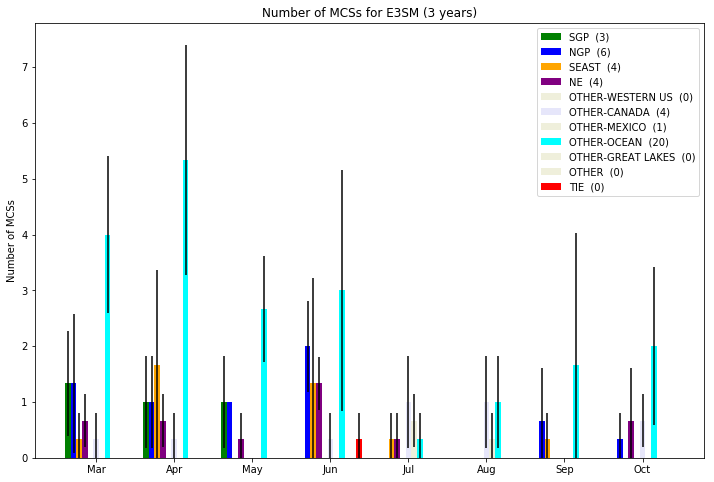

In [153]:
parse_and_plot(summary, 'e3sm');

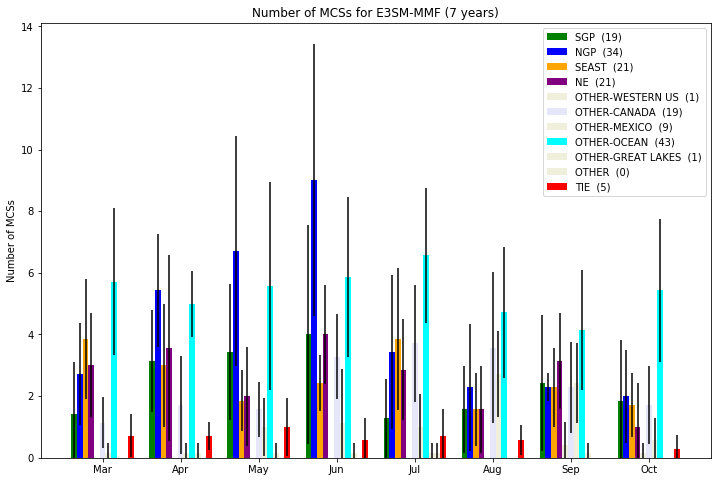

In [154]:
parse_and_plot(summary, 'e3sm-mmf');

In [48]:
import seaborn as sns
import pandas as pd

In [49]:
dfs = {}
for case, dat in origin_summary.items():
    # print(val for val in dat.values())
    ser = pd.Series(list(dat.values()),
                          index=pd.MultiIndex.from_tuples(dat.keys()))
    dfs[case] = ser.unstack().fillna(0)

Text(0.5, 1.0, 'E3SM')

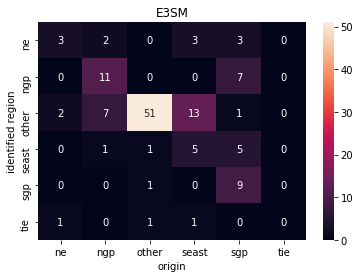

In [50]:
ax = sns.heatmap(dfs['e3sm'], annot=True)
ax.set_xlabel('origin')
ax.set_ylabel('identified region')
ax.set_title('E3SM')

Text(0.5, 1.0, 'E3SM-MMF')

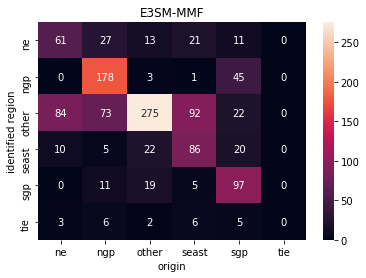

In [51]:
ax = sns.heatmap(dfs['e3sm-mmf'], annot=True, fmt='d')
ax.set_xlabel('origin')
ax.set_ylabel('identified region')
ax.set_title('E3SM-MMF')

In [67]:
origin_summary['e3sm']

{('sgp', 'sgp'): 9,
 ('sgp', 'ngp'): 0,
 ('sgp', 'seast'): 0,
 ('sgp', 'ne'): 0,
 ('sgp', 'other'): 1,
 ('ngp', 'sgp'): 6,
 ('ngp', 'ngp'): 9,
 ('ngp', 'seast'): 0,
 ('ngp', 'ne'): 0,
 ('ngp', 'other'): 0,
 ('seast', 'sgp'): 3,
 ('seast', 'ngp'): 0,
 ('seast', 'seast'): 4,
 ('seast', 'ne'): 0,
 ('seast', 'other'): 1,
 ('ne', 'sgp'): 2,
 ('ne', 'ngp'): 1,
 ('ne', 'seast'): 0,
 ('ne', 'ne'): 4,
 ('ne', 'other'): 0,
 ('other', 'sgp'): 5,
 ('other', 'ngp'): 11,
 ('other', 'seast'): 16,
 ('other', 'ne'): 2,
 ('other', 'other'): 54}

In [56]:
origins_df = pd.Series(origin_summary['e3sm'], )
origins_df

sgp    sgp       9
       ngp       0
       seast     0
       ne        0
       other     1
ngp    sgp       6
       ngp       9
       seast     0
       ne        0
       other     0
seast  sgp       3
       ngp       0
       seast     4
       ne        0
       other     1
ne     sgp       2
       ngp       1
       seast     0
       ne        4
       other     0
other  sgp       5
       ngp      11
       seast    16
       ne        2
       other    54
dtype: int64

In [49]:
sns.heatmap(origins_df['e3sm'])

IndexError: Inconsistent shape between the condition and the input (got (25, 1) and (25,))

In [22]:
summary

{'e3sm': {('sgp', 3): [2, 0, 2],
  ('sgp', 4): [2, 0, 1],
  ('sgp', 5): [0, 2, 1],
  ('sgp', 6): [0, 0, 0],
  ('sgp', 7): [0, 0, 0],
  ('sgp', 8): [0, 0, 0],
  ('sgp', 9): [0, 0, 0],
  ('sgp', 10): [0, 0, 0],
  ('ngp', 3): [1, 0, 2],
  ('ngp', 4): [0, 2, 1],
  ('ngp', 5): [1, 0, 1],
  ('ngp', 6): [1, 1, 2],
  ('ngp', 7): [0, 0, 0],
  ('ngp', 8): [0, 0, 0],
  ('ngp', 9): [0, 2, 0],
  ('ngp', 10): [0, 1, 0],
  ('seast', 3): [1, 0, 0],
  ('seast', 4): [4, 1, 0],
  ('seast', 5): [0, 0, 0],
  ('seast', 6): [0, 0, 2],
  ('seast', 7): [0, 0, 0],
  ('seast', 8): [0, 0, 0],
  ('seast', 9): [0, 0, 0],
  ('seast', 10): [0, 0, 0],
  ('other', 3): [4, 7, 5],
  ('other', 4): [5, 9, 5],
  ('other', 5): [5, 3, 2],
  ('other', 6): [3, 9, 7],
  ('other', 7): [5, 3, 0],
  ('other', 8): [3, 4, 0],
  ('other', 9): [5, 1, 0],
  ('other', 10): [3, 5, 2]},
 'e3sm-mmf': {('sgp', 3): [2, 0, 0, 4, 2, 1, 0],
  ('sgp', 4): [4, 3, 1, 3, 2, 2, 0],
  ('sgp', 5): [4, 1, 2, 4, 3, 4, 1],
  ('sgp', 6): [0, 1, 0, 7, 2, 7,

In [19]:
amts = [{key: len(val) for key, val in results[i].items()} for i in range(len(results))]
amts

[{('sgp', 3): 2,
  ('sgp', 4): 2,
  ('sgp', 5): 0,
  ('sgp', 6): 0,
  ('sgp', 7): 0,
  ('sgp', 8): 0,
  ('sgp', 9): 0,
  ('sgp', 10): 0,
  ('ngp', 3): 1,
  ('ngp', 4): 0,
  ('ngp', 5): 1,
  ('ngp', 6): 1,
  ('ngp', 7): 0,
  ('ngp', 8): 0,
  ('ngp', 9): 0,
  ('ngp', 10): 0,
  ('seast', 3): 1,
  ('seast', 4): 4,
  ('seast', 5): 0,
  ('seast', 6): 0,
  ('seast', 7): 0,
  ('seast', 8): 0,
  ('seast', 9): 0,
  ('seast', 10): 0,
  ('other', 3): 4,
  ('other', 4): 5,
  ('other', 5): 5,
  ('other', 6): 3,
  ('other', 7): 5,
  ('other', 8): 3,
  ('other', 9): 5,
  ('other', 10): 3},
 {('sgp', 3): 0,
  ('sgp', 4): 0,
  ('sgp', 5): 2,
  ('sgp', 6): 0,
  ('sgp', 7): 0,
  ('sgp', 8): 0,
  ('sgp', 9): 0,
  ('sgp', 10): 0,
  ('ngp', 3): 0,
  ('ngp', 4): 2,
  ('ngp', 5): 0,
  ('ngp', 6): 1,
  ('ngp', 7): 0,
  ('ngp', 8): 0,
  ('ngp', 9): 2,
  ('ngp', 10): 1,
  ('seast', 3): 0,
  ('seast', 4): 1,
  ('seast', 5): 0,
  ('seast', 6): 0,
  ('seast', 7): 0,
  ('seast', 8): 0,
  ('seast', 9): 0,
  ('seast', 

In [18]:
results[2]

{('sgp', 3): [2, 7],
 ('sgp', 4): [30],
 ('sgp', 5): [38],
 ('sgp', 6): [],
 ('sgp', 7): [],
 ('sgp', 8): [],
 ('sgp', 9): [],
 ('sgp', 10): [],
 ('ngp', 3): [15, 16],
 ('ngp', 4): [36],
 ('ngp', 5): [40],
 ('ngp', 6): [43, 50],
 ('ngp', 7): [],
 ('ngp', 8): [],
 ('ngp', 9): [],
 ('ngp', 10): [],
 ('seast', 3): [],
 ('seast', 4): [],
 ('seast', 5): [],
 ('seast', 6): [45, 47],
 ('seast', 7): [],
 ('seast', 8): [],
 ('seast', 9): [],
 ('seast', 10): [],
 ('other', 3): [5, 10, 12, 13, 23],
 ('other', 4): [24, 25, 27, 28, 35],
 ('other', 5): [37, 39],
 ('other', 6): [41, 42, 46, 48, 49, 51, 52],
 ('other', 7): [],
 ('other', 8): [],
 ('other', 9): [],
 ('other', 10): [59, 60]}

In [17]:
# write dataset to file
lons = pix_ds.lon
lats = pix_ds.lat
ntrackmax = 311

In [18]:
data = np.empty((len(years), len(months), len(lats), len(lons)), dtype=np.int)

In [19]:
sorted_keys = sorted([k for k in yearly_counts.keys()])
for ny, yr in enumerate(sorted_keys):
    for ns, month in enumerate(months):
        data[ny, ns, :, :] = yearly_counts[yr][month]

In [22]:
tracks = np.arange(1, ntrackmax, dtype=np.int)
print(tracks)
iland = 1
iwater = 2
# track_output:
track_data = np.zeros((len(years), len(tracks)), dtype=np.int)
for ny, yr in enumerate(sorted_keys):
    land_vals = np.array(land_inits[yr], dtype=np.int) - 1
    nonland_vals = np.array(water_inits[yr], dtype=np.int) - 1
    track_data[ny, land_vals] = iland
    track_data[ny, nonland_vals] = iwater
track_data[0, :]

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

array([2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1,
       1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2,
       2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2,
       1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [23]:
da_tracks = xr.DataArray(track_data, coords=[years, tracks],
                         dims=['year', 'track'],
                         name='init_loc',
                         attrs={'units': 'None', 
                                'long_name': 'initiation_location',
                                'notes': '1 = initiates over land, 2 = initiates over water, 0 = no track'}
                        )
# da_tracks

In [24]:
da = xr.DataArray(data, coords=[years, months, lats, lons],
                  dims=['year', 'month', 'lat', 'lon'],
                  name='mcs_count',
                  attrs={'units': 'None', 
                         'long_name': 'monthly_mcs_count',
                         'notes': 'excludes tracks that do not initiate over land'},
                 )
da

<xarray.DataArray 'mcs_count' (year: 7, month: 8, lat: 120, lon: 320)>
array([[[[0, ..., 0],
         ...,
         [0, ..., 0]],

        ...,

        [[0, ..., 0],
         ...,
         [0, ..., 0]]],


       ...,


       [[[0, ..., 0],
         ...,
         [0, ..., 0]],

        ...,

        [[0, ..., 0],
         ...,
         [0, ..., 0]]]])
Coordinates:
  * year     (year) datetime64[ns] 2001-06-30 2002-06-30 ... 2007-06-30
  * month    (month) int64 3 4 5 6 7 8 9 10
  * lat      (lat) float32 20.125 20.375 20.625 20.875 ... 49.375 49.625 49.875
  * lon      (lon) float32 220.125 220.375 220.625 ... 299.375 299.625 299.875
Attributes:
    units:      None
    long_name:  monthly_mcs_count
    notes:      excludes tracks that do not initiate over land

In [25]:
ds0 = xr.merge([da, da_tracks])
ds0

<xarray.Dataset>
Dimensions:    (lat: 120, lon: 320, month: 8, track: 310, year: 7)
Coordinates:
  * year       (year) datetime64[ns] 2001-06-30 2002-06-30 ... 2007-06-30
  * month      (month) int64 3 4 5 6 7 8 9 10
  * lat        (lat) float32 20.125 20.375 20.625 ... 49.375 49.625 49.875
  * lon        (lon) float32 220.125 220.375 220.625 ... 299.375 299.625 299.875
  * track      (track) int64 1 2 3 4 5 6 7 8 ... 303 304 305 306 307 308 309 310
Data variables:
    mcs_count  (year, month, lat, lon) int64 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2 0
    init_loc   (year, track) int64 2 1 1 2 2 2 2 1 1 1 1 ... 0 0 0 0 0 0 0 0 0 0

In [26]:
ds0.to_netcdf(topdir + '/monthly_mcs_count_land_only.nc')

In [27]:
dsx = ds0

In [29]:
# prepare figure canvas:
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

In [33]:
dat.lat

<xarray.DataArray 'lat' (lat: 120)>
array([20.125, 20.375, 20.625, 20.875, 21.125, 21.375, 21.625, 21.875, 22.125,
       22.375, 22.625, 22.875, 23.125, 23.375, 23.625, 23.875, 24.125, 24.375,
       24.625, 24.875, 25.125, 25.375, 25.625, 25.875, 26.125, 26.375, 26.625,
       26.875, 27.125, 27.375, 27.625, 27.875, 28.125, 28.375, 28.625, 28.875,
       29.125, 29.375, 29.625, 29.875, 30.125, 30.375, 30.625, 30.875, 31.125,
       31.375, 31.625, 31.875, 32.125, 32.375, 32.625, 32.875, 33.125, 33.375,
       33.625, 33.875, 34.125, 34.375, 34.625, 34.875, 35.125, 35.375, 35.625,
       35.875, 36.125, 36.375, 36.625, 36.875, 37.125, 37.375, 37.625, 37.875,
       38.125, 38.375, 38.625, 38.875, 39.125, 39.375, 39.625, 39.875, 40.125,
       40.375, 40.625, 40.875, 41.125, 41.375, 41.625, 41.875, 42.125, 42.375,
       42.625, 42.875, 43.125, 43.375, 43.625, 43.875, 44.125, 44.375, 44.625,
       44.875, 45.125, 45.375, 45.625, 45.875, 46.125, 46.375, 46.625, 46.875,
       47.125, 4

/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


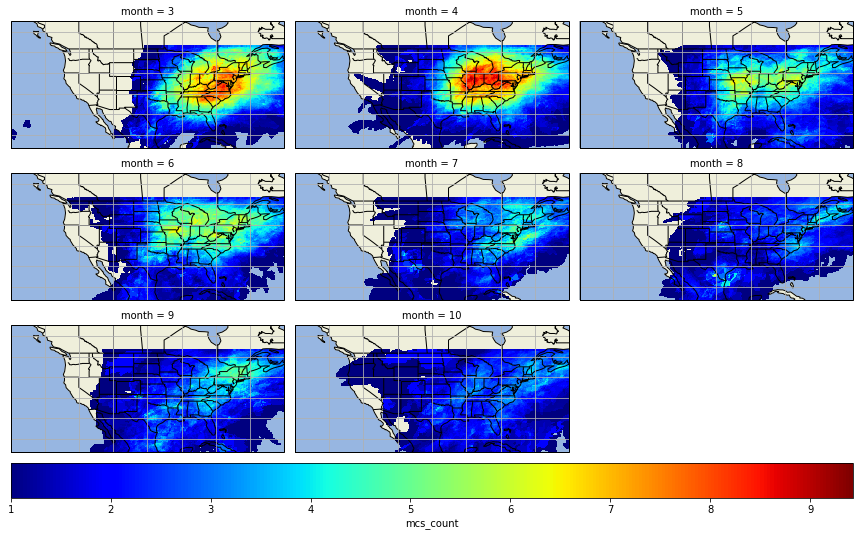

In [35]:
# E3SM

# dat = dsx['seasonal_mcs_count'].astype(np.float)
dat = dsx['mcs_count']
dat = dat.where(dat > 0)
# dat.values[dat.values <1e-3] = np.nan
# levs = range(2, 18, 2)
p = dat.mean(dim='year').plot(col='month', col_wrap=3, transform=ccrs.PlateCarree(),
                              subplot_kws={'projection': ccrs.PlateCarree()},
                              cbar_kwargs={'orientation': 'horizontal', 'pad': 0.02, 'aspect': 24},
                              cmap=plt.cm.jet, figsize=(12, 8))
for ax in p.axes.flatten():
    ax.add_feature(states_provinces, edgecolor='black', alpha=1)
    ax.coastlines()
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
    ax.add_feature(cfeature.LAND)
    ax.gridlines()
    ax.set_extent([dat.lon.values[0], dat.lon.values[-1], dat.lat.values[0], dat.lat.values[-1]])

In [10]:
da.to_netcdf(topdir + '/seasonal_mcs_count.nc')

In [11]:
dsx = xr.open_dataset(topdir + '/seasonal_mcs_count.nc')
dsx

<xarray.Dataset>
Dimensions:             (lat: 120, lon: 320, season: 3, year: 3)
Coordinates:
  * year                (year) datetime64[ns] 2001-06-30 2002-06-30 2003-06-30
  * season              (season) object 'MAM' 'JJA' 'SON'
  * lat                 (lat) float32 20.125 20.375 20.625 ... 49.625 49.875
  * lon                 (lon) float32 220.125 220.375 ... 299.625 299.875
Data variables:
    seasonal_mcs_count  (year, season, lat, lon) int64 ...

In [12]:
np.all(dsx['seasonal_mcs_count'].values == da.values)

True

/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


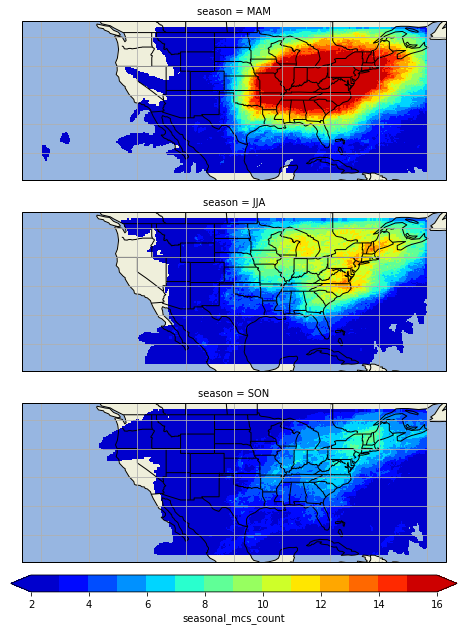

In [94]:
# E3SM-MMF: 
ds_mmf = xr.open_dataset('/global/cscratch1/sd/crjones/ECP/e3sm-mmf/seasonal_mcs_count_land_only.nc')
# dat = dsx['seasonal_mcs_count'].astype(np.float)
dat = ds_mmf['seasonal_mcs_count']
dat = dat.where(dat > 0)
# dat.values[dat.values <1e-3] = np.nan
levs = range(2, 17, 1)
p = dat.mean(dim='year').plot(row='season', transform=ccrs.PlateCarree(),
                                                subplot_kws={'projection': ccrs.PlateCarree()},
                                                cbar_kwargs={'orientation': 'horizontal', 'pad': 0.02, 'aspect': 24},
                                                cmap=plt.cm.jet, figsize=(8, 12),
                                                levels=levs,
                                               )
for ax in p.axes.flat:
    ax.add_feature(states_provinces, edgecolor='black', alpha=1)
    ax.coastlines()
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
    ax.add_feature(cfeature.LAND)
    ax.gridlines()

/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


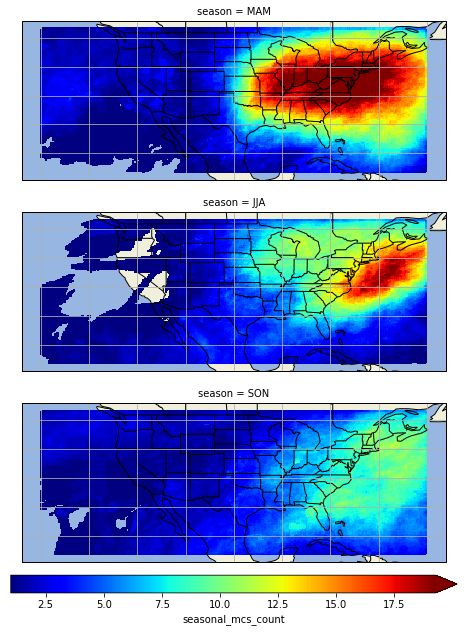

In [29]:
# MMF
ds_mmf = xr.open_dataset('/global/cscratch1/sd/crjones/ECP/e3sm-mmf/seasonal_mcs_count.nc')
dat = ds_mmf['seasonal_mcs_count']
dat = dat.where(dat > 0)
p = dat.mean(dim='year').plot(row='season', transform=ccrs.PlateCarree(),
                              subplot_kws={'projection': ccrs.PlateCarree()},
                              cbar_kwargs={'orientation': 'horizontal', 'pad': 0.02, 'aspect': 24},
                              cmap=plt.cm.jet, figsize=(8, 12), robust=True,
                             )
for ax in p.axes.flat:
    ax.add_feature(states_provinces, edgecolor='black', alpha=1)
    ax.coastlines()
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
    ax.add_feature(cfeature.LAND)
    ax.gridlines()